In [49]:
from os.path import join
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

SEED = 222
save_dir = join("..", "beira", "outdata")

## References
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://stackoverflow.com/questions/55286115/tensorflow-keras-can-conv2d-layers-now-accept-multispectral-images-meaning-ba

# Non-spatial ML models
## Prepare data
1. No missing data
2. Normalise features

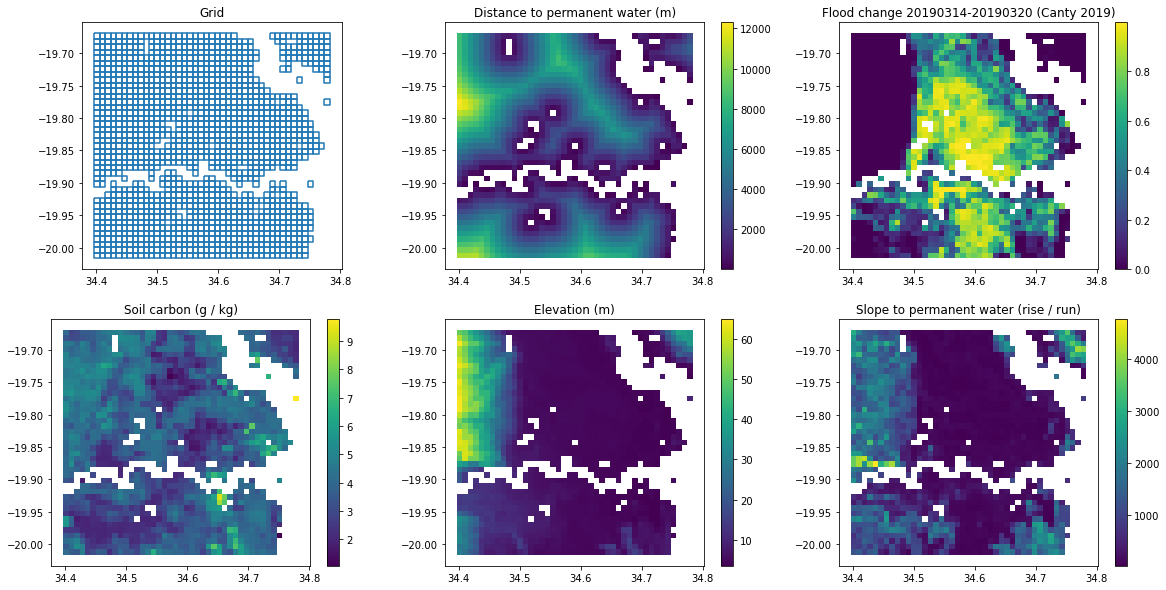

In [178]:
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp")).dropna()
feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")
feature_list.remove("geometry")

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

feature_gdf.boundary.plot(ax=ax[0, 0])
feature_gdf.plot(column="dist_pw", ax=ax[0, 1], legend=True)
feature_gdf.plot(column="floodfrac", ax=ax[0, 2], legend=True)

feature_gdf.plot(column="soilcarbon", ax=ax[1, 0], legend=True)
feature_gdf.plot(column="elevation", ax=ax[1, 1], legend=True)
feature_gdf.plot(column="slope", ax=ax[1, 2], legend=True)

ax[0, 0].set_title("Grid");
ax[0, 1].set_title("Distance to permanent water (m)");
ax[0, 2].set_title("Flood change 20190314-20190320 (Canty 2019)")
ax[1, 0].set_title("Soil carbon (g / kg)");
ax[1, 1].set_title("Elevation (m)");
ax[1, 2].set_title("Slope to permanent water (rise / run)");

In [202]:
# train test split
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp"))
feature_gdf = feature_gdf.drop(columns="jrc_permwa")
feature_gdf, geometry = feature_gdf.drop(columns="geometry"), feature_gdf["geometry"]
feature_gdf = feature_gdf.dropna()

feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")

X, y = feature_gdf.drop(columns="floodfrac"), feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list).head()

X_train: (1079, 11)
X_test: (360, 11)
y_train: (1079,)
y_test: (360,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,precipitat,dist_pw,slope_pw
0,0.565901,0.426475,0.546794,0.491360,0.373901,0.0,0.906715,0.747397,0.712918,0.357599,0.005354
1,0.073302,0.356542,0.499633,0.081366,0.106958,0.0,0.762333,0.680602,0.010343,0.072502,0.005477
2,0.017072,0.523484,0.520976,0.015946,0.316745,0.0,0.852735,0.793868,0.382363,0.576331,0.000099
3,0.039710,0.529502,0.554899,0.120144,0.137374,0.0,0.812705,0.723662,0.382363,0.212944,0.001149
4,0.019213,0.269490,0.520786,0.006393,0.161663,0.0,0.843715,0.825173,0.372627,0.370872,0.000347


## MLP parameters
Starting with [this tutorial](https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing).
#### Input
* **shape:** shape tuple, not including batch size, e.g. `shape=(12,)` means the input will be batches of 12-dimensional vectors. Elements can have value `None` which represent dimensions where shape isn't known.

#### Dense
* **units:** dimensionality of the output space
* **output:** n-d tensor with shape (batch_size, ..., units). E.g., for a 2D input with shape (batch_size, input_dim), the output would have shape (batch_size, units).

In [203]:
from tensorflow.keras.optimizers import RMSprop

mlp = Sequential(name='FloodFraction_MLP')

mlp.add(Input(shape=(X_train.shape[1],)))  # (#features,)
mlp.add(Dense(64, activation="relu", name="Layer1"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(64, activation="relu", name="Layer2"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(1,  activation="relu", name="RegressionLayer"))      # (batch_size, input_dim) -> (batch_size, 1) [regression]
optimizer = tf.keras.optimizers.RMSprop(0.001)
mlp.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

mlp.summary()

Model: "FloodFraction_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 64)                768       
                                                                 
 Layer2 (Dense)              (None, 64)                4160      
                                                                 
 RegressionLayer (Dense)     (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [204]:
EPOCHS = 500

history = mlp.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0)

So the average error in the validation set looks to be around 0.1504 which is quite significant.


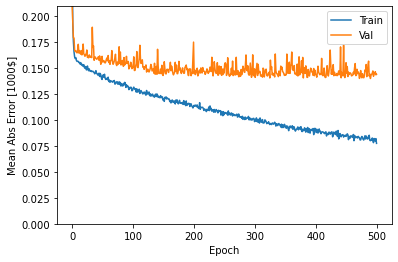

In [205]:
import numpy as np

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
    plt.legend()
    plt.ylim([0,max(history.history['val_mae'])])

plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}"
      f" which is quite significant.")

In [206]:
[loss, mae] = mlp.evaluate(X_test, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absolute error: 0.14


In [32]:
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

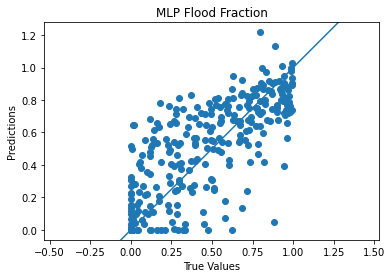

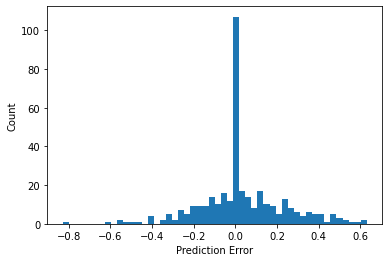

In [207]:
y_pred = mlp.predict(X_test).flatten()
plot_prediction(y_test, y_pred, title="MLP Flood Fraction")

### Conv1D Network
Requires input in the form `[batch_size, time_steps, input_dimension]` but currently data is in the form `[batch_size, features]`. So we pretty much convert the features into timesteps.

In [208]:
sample_size = X_train.shape[0]    # number of samples in train set
time_steps  = X_train.shape[1]    # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("Single sample shape:\n", X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

After reshape train data set shape:
 (1079, 11, 1)
Single sample shape:
 (11, 1)
An example sample:
 [[0.56590117]
 [0.42647509]
 [0.54679435]
 [0.4913605 ]
 [0.37390133]
 [0.        ]
 [0.90671482]
 [0.74739703]
 [0.7129182 ]
 [0.35759871]
 [0.0053544 ]]


And so [batch_size, time_steps, input_dimension] -> [1151, 12, 1]. That is, each sample has 12 time steps with 1 input dimension. You can also think as each sample has 12 rows 1 column!

In [209]:
from keras import Sequential
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D

In [210]:
n_timesteps = X_train_reshaped.shape[1]  # 12
n_features  = X_train_reshaped.shape[2]  # 1 

# build model
conv1D = Sequential(name="FloodFraction_Conv1D")
conv1D.add(Input(shape=(n_timesteps,n_features)))

# add three convolutional layers with (64, 32, 16) filters
conv1D.add(Conv1D(filters=64, kernel_size=6, activation='relu', name="Conv1D_1"))
conv1D.add(Dropout(0.5))
conv1D.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
conv1D.add(Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))

# max-pooling layer
conv1D.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))

conv1D.add(Flatten())

# add some dense layers
conv1D.add(Dense(32, activation='relu', name="Dense_1"))
conv1D.add(Dense(n_features, name="Dense_2"))

optimizer = RMSprop(0.001)

conv1D.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
conv1D.summary()

Model: "FloodFraction_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 6, 64)             448       
                                                                 
 dropout_4 (Dropout)         (None, 6, 64)             0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 3, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 16)            0         
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)       

In [211]:
# Store training stats
history = conv1D.fit(X_train_reshaped, y_train, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/500
27/27 [==============================] - 1s 8ms/step - loss: 0.1415 - mae: 0.3152 - val_loss: 0.0964 - val_mae: 0.2760
Epoch 2/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0890 - mae: 0.2621 - val_loss: 0.0713 - val_mae: 0.2350
Epoch 3/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0685 - mae: 0.2189 - val_loss: 0.0565 - val_mae: 0.1954
Epoch 4/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.2000 - val_loss: 0.0567 - val_mae: 0.1875
Epoch 5/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0600 - mae: 0.1898 - val_loss: 0.0522 - val_mae: 0.1788
Epoch 6/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0587 - mae: 0.1892 - val_loss: 0.0528 - val_mae: 0.1720
Epoch 7/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0551 - mae: 0.1811 - val_loss: 0.0519 - val_mae: 0.1725
Epoch 8/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0545 - m

Epoch 125/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0406 - mae: 0.1477 - val_loss: 0.0462 - val_mae: 0.1618
Epoch 126/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0384 - mae: 0.1470 - val_loss: 0.0447 - val_mae: 0.1623
Epoch 127/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0399 - mae: 0.1460 - val_loss: 0.0470 - val_mae: 0.1597
Epoch 128/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0409 - mae: 0.1465 - val_loss: 0.0436 - val_mae: 0.1584
Epoch 129/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0403 - mae: 0.1446 - val_loss: 0.0434 - val_mae: 0.1593
Epoch 130/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0370 - mae: 0.1394 - val_loss: 0.0446 - val_mae: 0.1557
Epoch 131/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0394 - mae: 0.1442 - val_loss: 0.0440 - val_mae: 0.1606
Epoch 132/500
27/27 [==============================] - 0s 3ms/step - 

Epoch 248/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0359 - mae: 0.1357 - val_loss: 0.0404 - val_mae: 0.1500
Epoch 249/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0354 - mae: 0.1357 - val_loss: 0.0422 - val_mae: 0.1485
Epoch 250/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0345 - mae: 0.1346 - val_loss: 0.0404 - val_mae: 0.1486
Epoch 251/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0350 - mae: 0.1357 - val_loss: 0.0458 - val_mae: 0.1570
Epoch 252/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0366 - mae: 0.1378 - val_loss: 0.0410 - val_mae: 0.1453
Epoch 253/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0355 - mae: 0.1344 - val_loss: 0.0419 - val_mae: 0.1484
Epoch 254/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0348 - mae: 0.1338 - val_loss: 0.0407 - val_mae: 0.1475
Epoch 255/500
27/27 [==============================] - 0s 2ms/step - 

Epoch 371/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0324 - mae: 0.1280 - val_loss: 0.0410 - val_mae: 0.1448
Epoch 372/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0321 - mae: 0.1279 - val_loss: 0.0375 - val_mae: 0.1376
Epoch 373/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0316 - mae: 0.1265 - val_loss: 0.0388 - val_mae: 0.1394
Epoch 374/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0318 - mae: 0.1276 - val_loss: 0.0391 - val_mae: 0.1432
Epoch 375/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0312 - mae: 0.1263 - val_loss: 0.0387 - val_mae: 0.1388
Epoch 376/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0328 - mae: 0.1298 - val_loss: 0.0385 - val_mae: 0.1394
Epoch 377/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0328 - mae: 0.1302 - val_loss: 0.0409 - val_mae: 0.1456
Epoch 378/500
27/27 [==============================] - 0s 2ms/step - 

Epoch 494/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0295 - mae: 0.1235 - val_loss: 0.0377 - val_mae: 0.1446
Epoch 495/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0284 - mae: 0.1198 - val_loss: 0.0391 - val_mae: 0.1423
Epoch 496/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0292 - mae: 0.1202 - val_loss: 0.0397 - val_mae: 0.1439
Epoch 497/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0283 - mae: 0.1202 - val_loss: 0.0397 - val_mae: 0.1425
Epoch 498/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0281 - mae: 0.1199 - val_loss: 0.0388 - val_mae: 0.1386
Epoch 499/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0305 - mae: 0.1242 - val_loss: 0.0386 - val_mae: 0.1385
Epoch 500/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0303 - mae: 0.1215 - val_loss: 0.0380 - val_mae: 0.1395


So the average error in the validation set looks to be around 0.1523


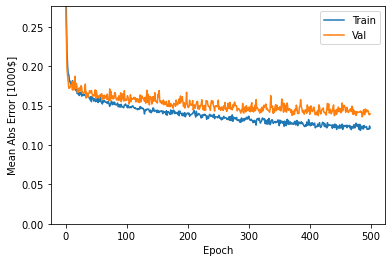

In [212]:
plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}")

In [213]:
[loss, mae] = conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absolute error: 0.14


In [214]:
print(features)

['elevation', 'aspect', 'curvature', 'slope', 'soilcarbon', 'mangroves', 'ndvi_mfmas', 'evi_mfmask', 'precipitat', 'floodfrac', 'dist_pw', 'slope_pw']


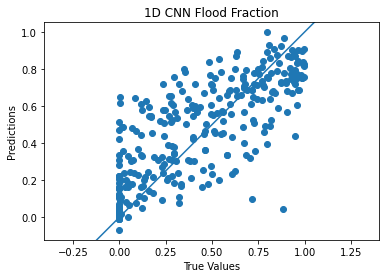

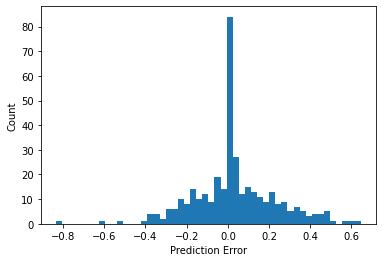

In [215]:
y_pred = conv1D.predict(X_test_reshaped).flatten()
plot_prediction(y_test, y_pred, title="1D CNN Flood Fraction")

## Aspatial and spatial random forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [18]:
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp")).dropna()
feature_gdf["lon"] = feature_gdf.geometry.centroid.x
feature_gdf["lat"] = feature_gdf.geometry.centroid.y
feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")
feature_list.remove("geometry")

feature_list_aspatial = feature_list[:-2]
feature_list_spatial = feature_list

/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_46372/351396300.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feature_gdf["lon"] = feature_gdf.geometry.centroid.x
/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_46372/351396300.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feature_gdf["lat"] = feature_gdf.geometry.centroid.y


### Aspatial random forest

In [56]:
X, y = feature_gdf[feature_list_aspatial], feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
#nscaler = MinMaxScaler(feature_range=(0, 1))
#nscaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list_aspatial).head()

X_train: (1079, 12)
X_test: (360, 12)
y_train: (1079,)
y_test: (360,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw
171,38.372424,137.089179,5.799287e+06,2357.023282,4.324787,0.0,7955.210213,6103.952979,0.000000,0.018408,4403.505082,0.008714
444,7.972485,122.228718,-6.846549e+06,412.854979,2.000000,0.0,6740.650532,5574.772234,0.002872,0.010459,895.596702,0.008902
1003,4.502319,157.703114,-1.123548e+06,102.639805,3.827021,0.0,7501.119894,6472.119043,0.005745,0.014668,7094.854998,0.000635
833,5.899434,158.981833,7.972362e+06,596.736503,2.264894,0.0,7164.381489,5915.908723,0.210319,0.014668,2623.626267,0.002249
639,4.634448,103.730700,-1.174498e+06,57.340908,2.476421,0.0,7425.244574,6720.132128,0.000000,0.014558,4566.829192,0.001015


mean absolute error: 0.12243740183046674


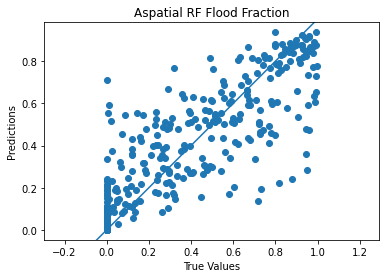

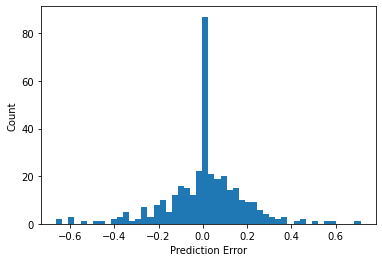

In [57]:
regr = RandomForestRegressor(random_state=SEED)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(f"mean absolute error: {mean_absolute_error(y_test, y_pred)}")
plot_prediction(y_test, y_pred, title="Aspatial RF Flood Fraction")

## Spatial random forest

In [52]:
X, y = feature_gdf[feature_list_spatial], feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list_spatial).head()

X_train: (1079, 14)
X_test: (360, 14)
y_train: (1079,)
y_test: (360,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw,lon,lat
0,0.565901,0.426475,0.546794,0.491360,0.373901,0.0,0.906715,0.747397,0.000000,0.712918,0.357599,0.005354,0.095238,0.924926
1,0.073302,0.356542,0.499633,0.081366,0.106958,0.0,0.762333,0.680602,0.001947,0.010343,0.072502,0.005477,0.238095,0.399744
2,0.017072,0.523484,0.520976,0.015946,0.316745,0.0,0.852735,0.793868,0.003894,0.382363,0.576331,0.000099,0.547619,0.074926
3,0.039710,0.529502,0.554899,0.120144,0.137374,0.0,0.812705,0.723662,0.142574,0.382363,0.212944,0.001149,0.452381,0.124883
4,0.019213,0.269490,0.520786,0.006393,0.161663,0.0,0.843715,0.825173,0.000000,0.372627,0.370872,0.000347,0.357143,0.774815


mean absolute error: 0.10367291987134139


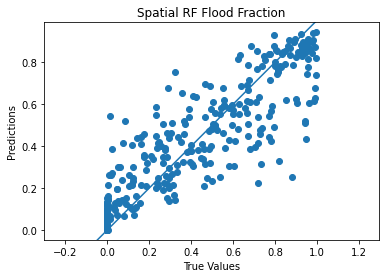

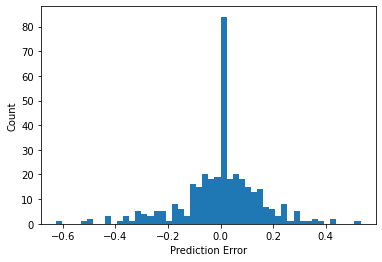

In [55]:
regr = RandomForestRegressor(random_state=SEED)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(f"mean absolute error: {mean_absolute_error(y_test, y_pred)}")
plot_prediction(y_test, y_pred, title="Spatial RF Flood Fraction")

## Extra
### Code dataframe into matrix representing spatial grid

    # get dimensions, TODO: make this more elegant
    from shapely.geometry import box
    feature_gdf_pm = feature_gdf.to_crs("EPSG:3857")
    bbounds = feature_gdf_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / 1000, 0))
    ncols = int(np.round(width  / 1000, 0))
    print(f"nrows:{nrows}, ncols: {ncols}")

    def reshape_df(df, nrows, ncols):
        feature_mat = np.empty(shape=(len(feature_list), nrows, ncols), dtype="object")
        for i, feature in enumerate(feature_list):
            feature_arr = df[feature].values.reshape(42, 43, order="F")
            feature_mat[i, :, :] = feature_arr

            return feature_mat

    reshape_df(X_train, nrows, ncols)